# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models as ml
from keras import layers as l

from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn import model_selection as ms

from xgboost import XGBClassifier

from scipy.stats import chi2_contingency
from scikitplot import metrics as mt

import time

time_init = time.time()

## 0.1 Importing Data

In [2]:
users_raw = pd.read_csv('D:\\My Drive\\Pessoal\\projetos\\airbnb_first_booking_predict\\data\\raw\\train_users_2.csv')
sessions_raw = pd.read_csv('D:\\My Drive\\Pessoal\\projetos\\airbnb_first_booking_predict\\data\\raw\\sessions.csv')

## 0.2 Helper Functions

In [3]:
# correlations between categorical attributes by Pearson method
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)

# identificando outliers
def search_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
#     print(f'O limite inferior é: {li}\nO limite superior é: {ls}\nHá {len(indices)} outliers')
    return indices, li, ls

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

# 1.0 Data Description

In [4]:
users1 = users_raw.copy()
sessions1 = sessions_raw.copy()

## 1.1 Looking Dataset

In [5]:
users1.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


* A data da criação da conta em alguns casos é posterior a data do primeiro booking

In [6]:
sessions1.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## 1.2 Data Dimension

In [7]:
print('Usuários')
print(f'Há: {users1.shape[0]} linhas no total')
print(f'Há: {users1.shape[1]} colunas no total')

Usuários
Há: 213451 linhas no total
Há: 16 colunas no total


In [8]:
print('Sessions')
print(f'Há: {sessions1.shape[0]} linhas no total')
print(f'Há: {sessions1.shape[1]} colunas no total')

Sessions
Há: 10567737 linhas no total
Há: 6 colunas no total


## 1.3 Datatypes

In [9]:
print('Usuários')
users1.dtypes

Usuários


id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [10]:
print('Navegação')
sessions1.dtypes

Navegação


user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.4 Check Na

In [11]:
print('Usuários')
users1.isna().sum()  / users1['id'].count()

Usuários


id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
print('Sessions')
sessions1.isna().sum() / sessions1['user_id'].count()

Sessions


user_id          0.003275
action           0.007559
action_type      0.106919
action_detail    0.106919
device_type      0.000000
secs_elapsed     0.012914
dtype: float64

* action_type e action_detail possuem a mesma quantidade de NaN's, aparentemente ou são altamente correlacionadas ou são derivadas de uma mesma característica

## 1.5 Filout Na

### 1.5.1 Users

In [13]:
users1_qtd_base = users1.shape[0]

<AxesSubplot:>

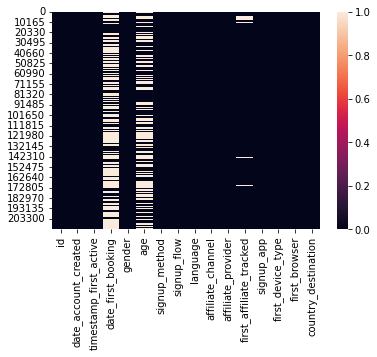

In [14]:
sns.heatmap(users1.isna())

#### 1.5.1 date_first_booking

In [15]:
users1[users1['date_first_booking'].isna()]['country_destination'].value_counts()

NDF    124543
Name: country_destination, dtype: int64

Usuários que ainda não fizeram um "booking" são classificados como "NDF (No Destination Found)", e são NaN's em date_first_booking. Para completar os dados dessa feature, em um ambiente empresarial real o input dos dados faltantes dessa feature se daria pela data atual, como o dataset é de dados históricos, os dados serão inputados com a data máxima do dataset.

#### 1.5.2 age

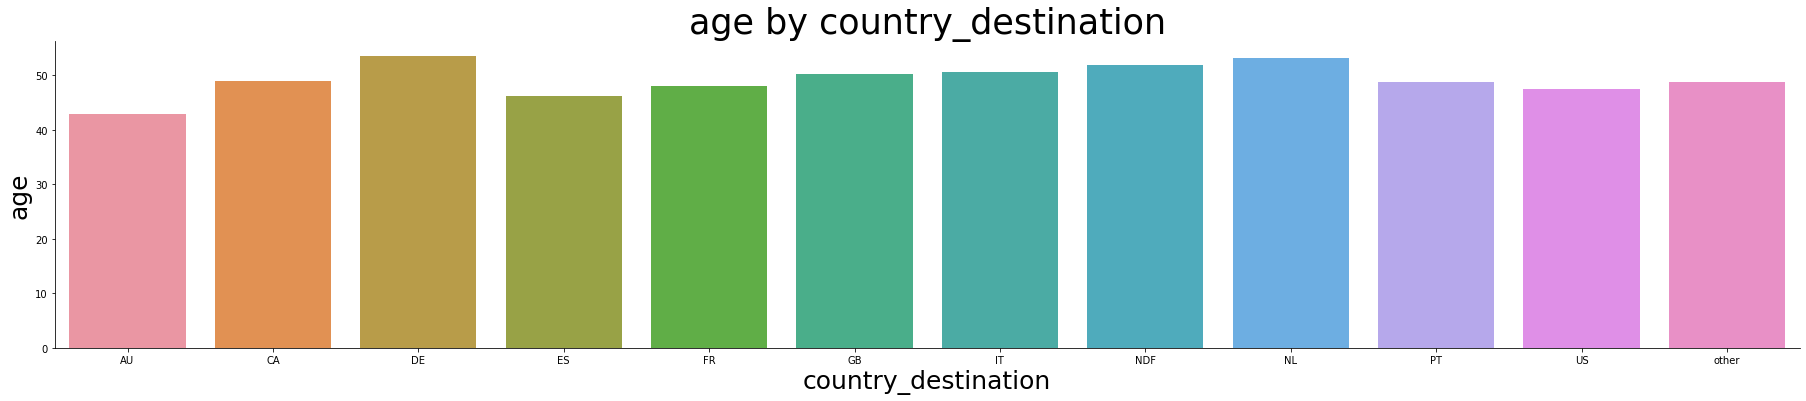

In [16]:
temp = users1.groupby('country_destination').agg({'age': 'mean'}).reset_index()
sns.catplot(data=temp, x='country_destination', y='age', kind='bar', aspect=5)
plt.title('age by country_destination', fontsize=35)
plt.xlabel('country_destination', fontsize=25)
plt.ylabel('age', fontsize=25);

A distribuição parece uniforme em todas as categorias de country_destination

D:\My Drive\Pessoal\environments\data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


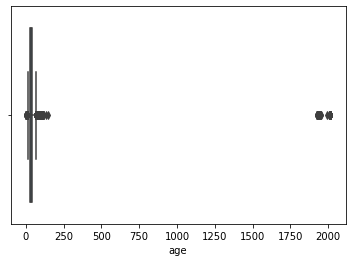

In [17]:
# plt.figure(figsize=(20, 5))
sns.boxplot(users1['age']);

* Outliers com idade de 2000 anos, erros de input

In [18]:
print(f'Média = {users1["age"].mean()}')
print(f'Mediana = {users1["age"].median()}')

Média = 49.66833517985669
Mediana = 34.0


* Bastante deslocadas por conta dos outliers

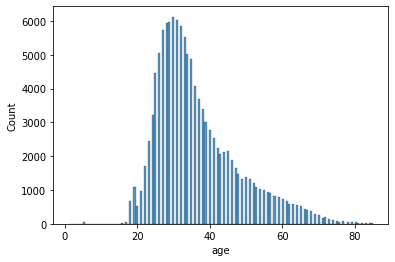

In [19]:
# plt.figure(figsize=(20, 5))
sns.histplot(users1.loc[users1['age']<=85, 'age']);

Parecida com uma NORMAL, apesar de possuir um SKEW POSITIVO (cauda direita mais pesada). Uma distribuição NORMAL com média e desvio padrão similares pode ser uma boa forma de substituição dos Nas

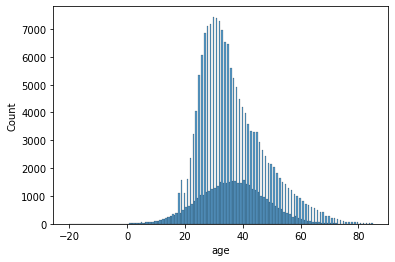

In [20]:
loc = users1.loc[users1['age']<=85, 'age'].mean()
scale = users1.loc[users1['age']<=85, 'age'].std()
size = temp = users1.loc[users1['age'].isna()]['id'].count()
random_norm_age = np.random.normal(loc=loc, scale=scale, size=size)
temp = users1.copy()
temp.loc[users1['age'].isna(), 'age'] = random_norm_age

sns.histplot(temp.loc[temp['age']<=85, 'age']);

#### 1.5.3 first_affiliate_tracked

In [21]:
users1['first_affiliate_tracked'].value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

In [22]:
users1[users1['first_affiliate_tracked'].isna()]['country_destination'].value_counts()

NDF      4327
US       1309
FR        124
other     113
IT         44
CA         37
ES         36
GB         29
DE         20
AU         12
NL         11
PT          3
Name: country_destination, dtype: int64

As amostras NaN's estão dispesas em todas as categorias de países destinos. Uma abortagem para este problema seria o input utilizando a frequência por categoria de country_destination, porém, tratando-se de uma variável categórica, onde há uma chance grande de inputarmos junto com isso um viés, e tratando-se de uma porcentagem baixa em relação ao total da base, droparemos as amostras com NaN's nessa feature.

#### 1.5.4 Filout Na

In [23]:
# date_first_booking
users1['date_account_created'] = pd.to_datetime(users1['date_account_created'])
temp = users1['date_account_created'].max().strftime('%Y-%m-%d')
users1['date_first_booking'].fillna(temp, inplace=True)

# age
loc = users1.loc[users1['age']<=85, 'age'].mean()
scale = users1.loc[users1['age']<=85, 'age'].std()
size = temp = users1.loc[users1['age'].isna()]['id'].count()
random_norm_age = np.random.normal(loc=loc, scale=scale, size=size)
users1.loc[users1['age'].isna(), 'age'] = random_norm_age

# first_affiliate_tracked
users1 = users1[~users1['first_affiliate_tracked'].isna()]

print(f'Porcentagem da base removida: {round((users1_qtd_base - users1.shape[0]) * 100/ users1_qtd_base, 2)}%')

Porcentagem da base removida: 2.84%


### 1.5.2 Sessions

In [24]:
sessions1_qtd_base = sessions1.shape[0]

<AxesSubplot:>

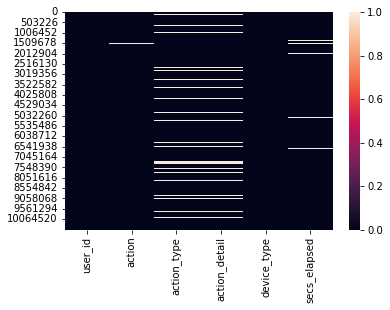

In [25]:
sns.heatmap(sessions1.isna())

* action_type e action_detail são NaN's juntamente

#### 1.5.2.1 user_id

user_id é a chave para a concatenação com users, portanto não há outra alternativa para o drop

#### 1.5.2.2 action

action possui somente 0.007 de NaN's, portanto será removida

#### 1.5.2.3 action_type e action_detail

In [26]:
sessions1['action_type'].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [27]:
sessions1.loc[sessions1['action_type'].isna(), 'action'].value_counts()

show                      582144
similar_listings_v2       168788
lookup                    162041
campaigns                 104709
track_page_view            81117
index                      16733
localization_settings       5403
uptodate                    3342
signed_out_modal            1058
currencies                   292
update                       225
check                        120
braintree_client_token       120
widget                        75
phone_verification            16
satisfy                        9
track_activity                 6
disaster_action                6
Name: action, dtype: int64

Diversificado demais para poder descobrir um padrão de reconhecimento de falha em action_type olhando para a action de origem. Provavelmente o que ocorre nas variáveis de sessions é uma arvore de classes onde o pai das classes é a action, e as outras variáveis são classificações dentro de action, e nem toda action possui uma classificação de action_type ou action_detail. Será criada uma categoria nova do tipo "without classification"

#### 1.5.2.4 secs_elapsed

secs_elapsed possui somente 0.01 de NaN's, portanto será removida

#### 1.5.2.5 Filout NaN's

In [28]:
# 'user_id'
sessions1 = sessions1.loc[~sessions1['user_id'].isna()]

# 'action'
sessions1 = sessions1.loc[~sessions1['action'].isna()]

# 'action_type'
sessions1.loc[sessions1['action_type'].isna(), 'action_type'] = 'without_classification'

# 'action_detail'
sessions1.loc[sessions1['action_detail'].isna(), 'action_detail'] = 'without_classification'

# 'secs_elapsed'
sessions1 = sessions1.loc[~sessions1['secs_elapsed'].isna()]

print(f'Porcentagem da base removida: {round((sessions1_qtd_base - sessions1.shape[0]) * 100/ sessions1_qtd_base, 2)}%')

Porcentagem da base removida: 2.21%


## 1.6 Changing datatype

### 1.6.1 users

In [29]:
# date_account_created
users1['date_account_created'] = pd.to_datetime(users1['date_account_created'])

# timestamp_first_active
users1['timestamp_first_active'] = pd.to_datetime(users1['timestamp_first_active'], format='%Y%m%d%H%M%S')
users1['timestamp_first_active'] = pd.to_datetime(users1['timestamp_first_active']).dt.strftime('%Y-%m-%d')

# date_first_booking
users1['date_first_booking'] = pd.to_datetime(users1['date_first_booking'])

# age
users1['age'] = users1['age'].astype(int)

# signup_flow
users1['signup_flow'] = users1['signup_flow'].astype('str')

### 1.6.2 sessions

## 1.7 Check Balanced Data

In [30]:
users1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.8 Descriptive Statistic

### 1.8.1 users

#### 1.8.1.1 Numerical Attributes

In [31]:
users_num_attributes = users1.select_dtypes(include=[int, float]).columns.to_list()

In [32]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(users1[users_num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(users1[users_num_attributes].apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(users1[users_num_attributes].apply(np.std)).T
d2 = pd.DataFrame(users1[users_num_attributes].apply(min)).T
d3 = pd.DataFrame(users1[users_num_attributes].apply(max)).T
d4 = pd.DataFrame(users1[users_num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(users1[users_num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(users1[users_num_attributes].apply(lambda x: x.kurtosis())).T

temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
age,-10.0,2014.0,2024.0,43.874066,35.0,118.824545,16.300573,266.905342


* age com números negativos, e pessoas máxima com erro também, média e mediana bastante deslocadas por conta de outliers, desvio padrão altíssimo, skew alta positiva, o que sugere causa direita mais pesada e kurtosis com um pico muito elevado. Os dados sugerem uma POISON com erros de input. Por exemplo, a idade máxima parece estar bastante ligada ao ano da data atual.
* signup_flow com range de 25, média de 3.15 e mediana de 0, o que indicam muitos valores zerados, skew e kurtosis sugerem uma Normal, mas considerando os outros parâmetros, deve estar mais próxima a uma POISON

#### 1.8.1.2 Cattegorical Attributes

In [33]:
users_cat_attributes = users1.select_dtypes(exclude=[int, float, 'datetime64[ns]']).columns.to_list()
users_cat_attributes.remove('id')

In [34]:
users1[users_cat_attributes].describe().T

,count,unique,top,freq
timestamp_first_active,207386,1635,2014-05-13,672
gender,207386,4,-unknown-,91783
signup_method,207386,3,basic,148297
signup_flow,207386,17,0,163180
language,207386,25,en,200415
affiliate_channel,207386,8,direct,134179
affiliate_provider,207386,18,direct,133935
first_affiliate_tracked,207386,7,untracked,109232
signup_app,207386,4,Web,178334
first_device_type,207386,9,Mac Desktop,89600


* linguage, affiliate_provider e first_browser com muitas dimensões 

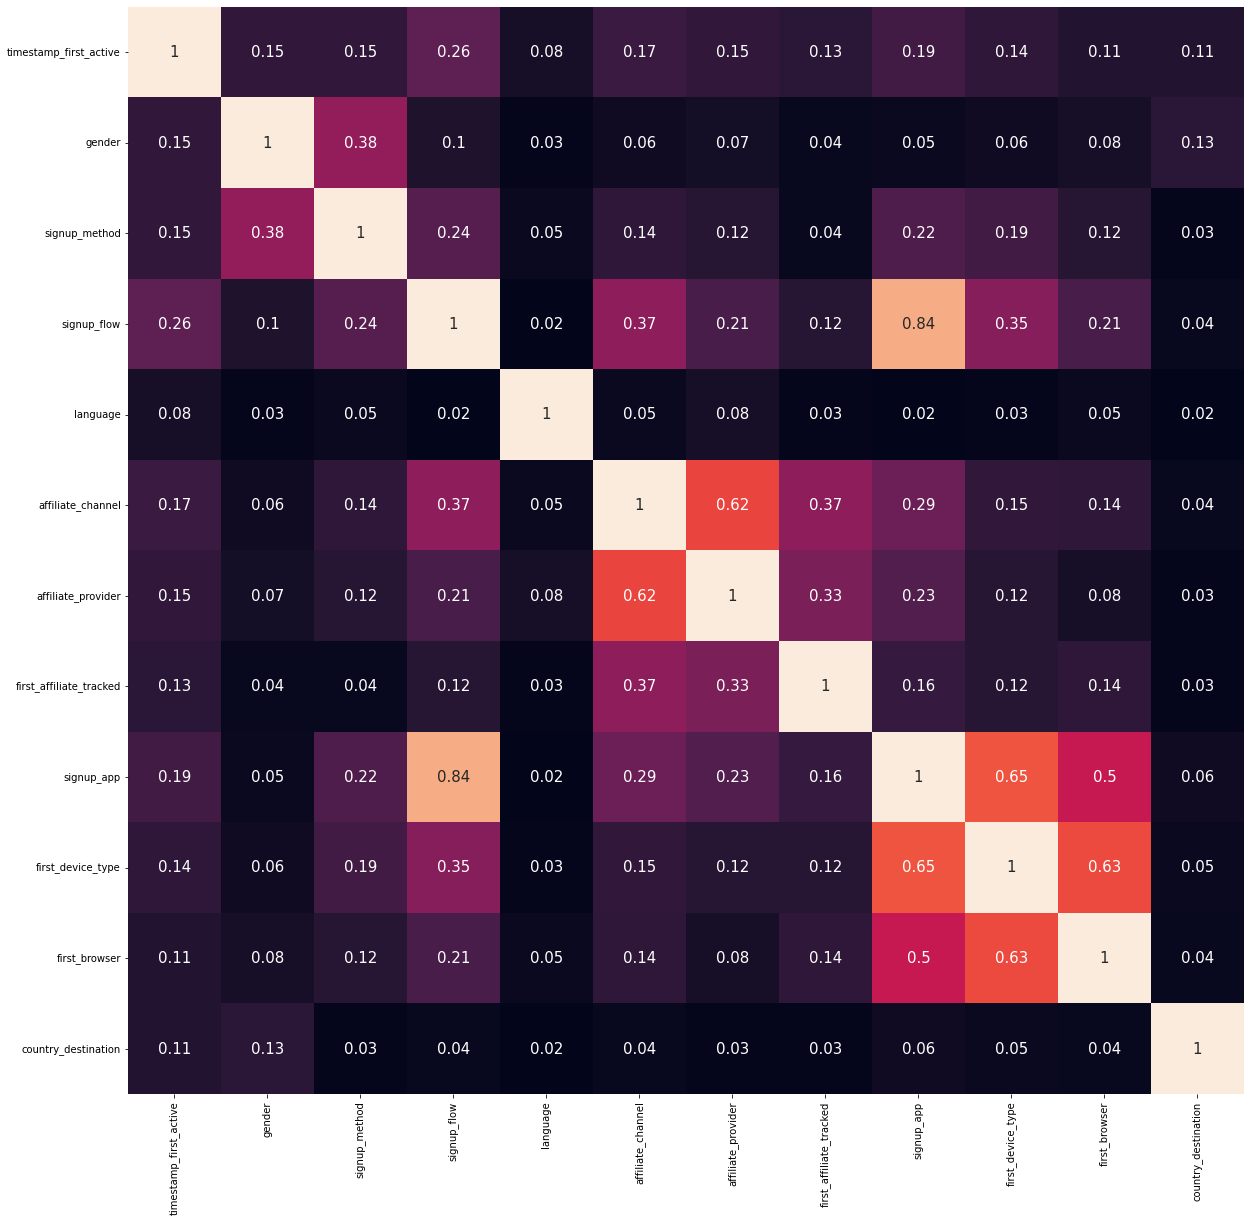

In [35]:
cramer_correlation = []
temp = users1[users_cat_attributes]
n_cols = len(temp.columns.to_list())

for i, col_1 in enumerate(temp[users_cat_attributes]):
    for j, col_2 in enumerate(temp[users_cat_attributes]):
        cramer_correlation.append(cramer_v(temp[col_1], temp[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(n_cols, n_cols), index=users_cat_attributes, columns=users_cat_attributes)

plt.figure(figsize=(20, 20))
sns.heatmap(matrix, annot=True, cbar=False, annot_kws={'fontsize':15});

Correlações no máximo altas.

### 1.8.2 sessions

#### 1.8.2.1 Numerical Attributes

In [36]:
sessions_num_attributes = sessions1.select_dtypes(include=[int, float]).columns.to_list()

In [37]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(sessions1[sessions_num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(sessions1[sessions_num_attributes].apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(sessions1[sessions_num_attributes].apply(np.std)).T
d2 = pd.DataFrame(sessions1[sessions_num_attributes].apply(min)).T
d3 = pd.DataFrame(sessions1[sessions_num_attributes].apply(max)).T
d4 = pd.DataFrame(sessions1[sessions_num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(sessions1[sessions_num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(sessions1[sessions_num_attributes].apply(lambda x: x.kurtosis())).T

temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,18852.061447,1132.0,87471.902045,11.377108,161.061418


* sects_elapse com valores zerados, o que não faz sentido para o negócio, skew e kurtosis super altos, média e mediana extremamente deslocados, range gigantesco.

#### 1.8.2.2 Cattegorical Attributes

In [38]:
sessions_cat_attributes = sessions1.select_dtypes(exclude=[int, float, 'datetime64[ns]']).columns.to_list()
sessions_cat_attributes.remove('user_id')

In [39]:
sessions1[sessions_cat_attributes].describe()

,action,action_type,action_detail,device_type
count,10333696,10333696,10333696,10333696
unique,359,11,156,14
top,show,view,view_search_results,Mac Desktop
freq,2758841,3545621,1770931,3513600


* muitas dimensões em action e action_detail, o que dificulta a parte de encoding

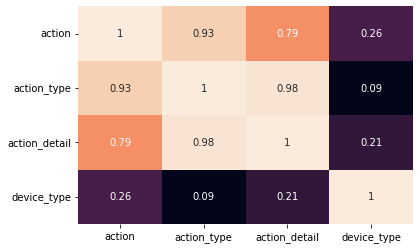

In [40]:
cramer_correlation = []
temp = sessions1[sessions_cat_attributes]
n_cols = len(temp.columns.to_list())

for i, col_1 in enumerate(temp[sessions_cat_attributes]):
    for j, col_2 in enumerate(temp[sessions_cat_attributes]):
        cramer_correlation.append(cramer_v(temp[col_1], temp[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(n_cols, n_cols), index=sessions_cat_attributes, columns=sessions_cat_attributes)

# plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False);

* action e action_type altamente correlacionadas, o que sugere que carreguem o mesmo tipo de informação, possivelmente seja mais interessnate trabalhar somente com uma das duas, para manter coerência de acordo com a Navalha de Occam
* mesmo caso com action_type e action_detail 

## 1.9 Pivot, Concatenation and Data Description Integral Dataframe

In [41]:
sessions1.rename(columns = {'user_id':'id'}, inplace=True)

temp = pd.pivot_table(data = sessions1, index='id', columns='action_type', values='secs_elapsed', aggfunc='sum').fillna(0)

df1 = users1.merge(temp, how='left', on='id')

temp = sessions1.groupby('id').agg({'device_type':'max'})

df1 = df1.merge(temp, how='left', on='id')

### 1.9.1 Looking dataframe

In [42]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,booking_response,click,data,message_post,modify,partner_callback,submit,view,without_classification,device_type
0,gxn3p5htnn,2010-06-28,2009-03-19,2014-06-30,-unknown-,38,facebook,0,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23,2014-06-30,MALE,38,facebook,0,en,seo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09,2010-08-02,FEMALE,56,basic,3,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,FEMALE,42,facebook,0,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41,basic,0,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.9.2 Data Dimensions

In [43]:
print(f'Há: {df1.shape[0]} linhas no total')
print(f'Há: {df1.shape[1]} colunas no total')

Há: 207386 linhas no total
Há: 28 colunas no total


### 1.9.3 Check NaN's

In [44]:
df1.isna().sum() / df1['id'].count()

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.000000
gender                     0.000000
age                        0.000000
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.000000
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
-unknown-                  0.651543
booking_request            0.651543
booking_response           0.651543
click                      0.651543
data                       0.651543
message_post               0.651543
modify                     0.651543
partner_callback           0.651543
submit                     0.651543
view                       0.651543
without_classification     0.651543
device_type                0

In [45]:
set_sessions = sessions1['id'].drop_duplicates()
set_users = users1['id'].drop_duplicates()

In [46]:
print(f'Quantidade de "id" que estão em sessions e não estão em users: {len(set(set_sessions) - set(set_users))}')

Quantidade de "id" que estão em sessions e não estão em users: 61633


In [47]:
print(f'Quantidade de "id" que estão em users e não estão em sessions: {len(set(set_users) - set(set_sessions))}')

Quantidade de "id" que estão em users e não estão em sessions: 135121


### 1.9.4 FIlout NaN Values

In [48]:
# device_type
df1['device_type'] = df1['device_type'].fillna('-unknown-')

# action_type
df1.fillna(0, inplace=True)

### 1.9.5 Data Types

In [49]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active             object
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                        object
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
-unknown-                         float64
booking_request                   float64
booking_response                  float64
click                             float64
data                              float64
message_post                      float64
modify                            float64
partner_callback                  

### 1.9.6 Changing Dtypes

In [50]:
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'])

# 2.0 Feature Engineering

In [51]:
df2 = df1.copy()

In [52]:
# removing time from datetime features
df2['date_account_created'] = pd.to_datetime(df2['date_account_created'].dt.strftime('%Y-%m-%d' ))
df2['timestamp_first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['date_first_booking'] = pd.to_datetime(df2['date_first_booking'].dt.strftime('%Y-%m-%d'))

# tempo entre primeira ação e booking
df2['delta_between_first_active_and_booking'] = (df2['date_first_booking'] - df2['timestamp_first_active']).apply(lambda x: x.days)

# tempo entre primeira ação e criação da conta
df2['delta_between_first_active_and_account_created'] = (df2['date_account_created'] - df2['timestamp_first_active']).apply(lambda x: x.days)

# tempo entre criação da conta e booking
df2['delta_between_account_created_and_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ================== First Active ==================
# year first active
df2['year_first_active'] = df2['timestamp_first_active'].dt.year

# month first active
df2['month_fist_active'] = df2['timestamp_first_active'].dt.month

# day first active
df2['day_first_active'] = df2['timestamp_first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['timestamp_first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['timestamp_first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

C:\Users\Samoel\AppData\Local\Temp\ipykernel_10984\1724316629.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['timestamp_first_active'].dt.weekofyear
C:\Users\Samoel\AppData\Local\Temp\ipykernel_10984\1724316629.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
C:\Users\Samoel\AppData\Local\Temp\ipykernel_10984\1724316629.py:61: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 3.0 Exploratory Data Analysis

In [53]:
df3 = df2.copy()

* A data da criação da conta em alguns casos é posterior a data do primeiro booking
* Age Outliers com idade de 2000 anos, erros de input
* Age Bastante deslocadas por conta dos outliers
* age com números negativos, e pessoas máxima com erro também, média e mediana bastante deslocadas por conta de outliers, desvio padrão altíssimo, skew alta positiva, o que sugere causa direita mais pesada e kurtosis com um pico muito elevado. Os dados sugerem uma POISON com erros de input. Por exemplo, a idade máxima parece estar bastante ligada ao ano da data atual.
* signup_flow com range de 25, média de 3.15 e mediana de 0, o que indicam muitos valores zerados, skew e kurtosis sugerem uma Normal, mas considerando os outros parâmetros, deve estar mais próxima a uma POISON
* action_type e action_detail possuem a mesma quantidade de NaN's, aparentemente ou são altamente correlacionadas ou são derivadas de uma mesma característica
* action_type e action_detail são NaN's juntamente
* muitas dimensões em action e action_detail, o que dificulta a parte de encoding
* linguage, affiliate_provider e first_browser com muitas dimensões 
* action e action_type altamente correlacionadas, o que sugere que carreguem o mesmo tipo de informação, possivelmente seja mais interessnate trabalhar somente com uma das duas, para manter coerência de acordo com a Navalha de Occam
* mesmo caso com action_type e action_detail 
* sects_elapse com valores zerados, o que não faz sentido para o negócio, skew e kurtosis super altos, média e mediana extremamente deslocados, range gigantesco.

# 4.0 Data Filtering

In [54]:
df4 = df3.copy()

## 4.1 Filtering Rows

In [55]:
temp = df4.shape[0]

# age
idx, li, ls = search_outliers(df4, 'age')
df4.drop(idx, inplace=True)

print(f'Quantidade de outliers descartados: {round(100 * (temp - df4.shape[0]) / temp, 2)}%')

Quantidade de outliers descartados: 2.96%


## 4.2 Columns Selection

# 5.0 Data Preparation

In [56]:
df5 = df4.copy()

## 5.2 Target

In [57]:
# 'country_destination'
le_country_destination = pp.LabelEncoder().fit(df5['country_destination'])
df5['country_destination'] = le_country_destination.transform(df5['country_destination'])

## 5.3 Features

### 5.3.1 Normalize

In [58]:
# STANDARDSCALER TRANSFORMATION

# 'secs_elapsed'
ss_secs_elapsed = pp.StandardScaler()
ss_secs_elapsed = ss_secs_elapsed.fit(sessions1[['secs_elapsed']].values)

cols_standard_scaler = ['-unknown-', 'booking_request', 'booking_response', 'click', 'data', 'message_post', 'modify', 'partner_callback', 'submit', 'view', 'without_classification']

for i in cols_standard_scaler:
    df5[i] = ss_secs_elapsed.transform(df5[[i]].values)

# LOG TRANSFORMATION

# 'delta_between_first_active_and_booking'
df5['delta_between_first_active_and_booking'] = np.log1p(df5['delta_between_first_active_and_booking'])

# 'delta_between_first_active_and_account_created'
df5['delta_between_first_active_and_account_created'] = np.log1p(df5['delta_between_first_active_and_account_created'])

# 'delta_between_account_created_and_booking'
df5['delta_between_account_created_and_booking'] = np.log1p(df5['delta_between_account_created_and_booking'])

D:\My Drive\Pessoal\environments\data_science\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\My Drive\Pessoal\environments\data_science\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 5.3.2 Rescaling

In [59]:
# 'age'
mm_age = pp.MinMaxScaler().fit(df5[['age']].values)
df5['age'] = mm_age.transform(df5[['age']].values)

### 5.3.3 Transformations

#### 5.3.3.1 Encoding

Para este ciclo as características particulares das features serão ignoradas, e encodadas por frequência (importancia)

In [60]:
# 'gender'
map_gender = df5.groupby('gender').agg({'country_destination':'count'})['country_destination']
df5['gender'] = df5['gender'].map(map_gender) / df5['id'].count()

# 'signup_method'
map_signup_method = df5.groupby('signup_method').agg({'country_destination':'count'})['country_destination']
df5['signup_method'] = df5['signup_method'].map(map_signup_method) / df5['id'].count()

# 'signup_flow'
map_signup_flow = df5.groupby('signup_flow').agg({'country_destination':'count'})['country_destination']
df5['signup_flow'] = df5['signup_flow'].map(map_signup_flow) / df5['id'].count()

# 'language'
map_language = df5.groupby('language').agg({'country_destination':'count'})['country_destination']
df5['language'] = df5['language'].map(map_language) / df5['id'].count()

# 'affiliate_channel'
map_affiliate_channel = df5.groupby('affiliate_channel').agg({'country_destination':'count'})['country_destination']
df5['affiliate_channel'] = df5['affiliate_channel'].map(map_affiliate_channel) / df5['id'].count()

# 'affiliate_provider'
map_affiliate_provider = df5.groupby('affiliate_provider').agg({'country_destination':'count'})['country_destination']
df5['affiliate_provider'] = df5['affiliate_provider'].map(map_affiliate_provider) / df5['id'].count()

# 'first_affiliate_tracked'
map_first_affiliate_tracked = df5.groupby('first_affiliate_tracked').agg({'country_destination':'count'})['country_destination']
df5['first_affiliate_tracked'] = df5['first_affiliate_tracked'].map(map_first_affiliate_tracked) / df5['id'].count()

# 'signup_app'
map_signup_app = df5.groupby('signup_app').agg({'country_destination':'count'})['country_destination']
df5['signup_app'] = df5['signup_app'].map(map_signup_app) / df5['id'].count()

# 'first_device_type'
map_first_device_type = df5.groupby('first_device_type').agg({'country_destination':'count'})['country_destination']
df5['first_device_type'] = df5['first_device_type'].map(map_first_device_type) / df5['id'].count()

# 'first_browser'
map_first_browser = df5.groupby('first_browser').agg({'country_destination':'count'})['country_destination']
df5['first_browser'] = df5['first_browser'].map(map_first_browser) / df5['id'].count()

# signup_flow
map_signup_flow = df5.groupby('signup_flow').agg({'country_destination':'count'})['country_destination']
df5['signup_flow'] = df5['signup_flow'].map(map_signup_flow) / df5['id'].count()

# 'device_type'
map_device_type = df5.groupby('device_type').agg({'country_destination':'count'})['country_destination']
df5['device_type'] = df5['device_type'].map(map_device_type) / df5['id'].count()

# year_first_active
map_year_first_active = df5.groupby('year_first_active').agg({'country_destination':'count'})['country_destination']
df5['year_first_active'] = df5['year_first_active'].map(map_year_first_active) / df5['id'].count()

# year_first_booking
map_year_first_booking = df5.groupby('year_first_booking').agg({'country_destination':'count'})['country_destination']
df5['year_first_booking'] = df5['year_first_booking'].map(map_year_first_booking) / df5['id'].count()

# year_account_created
map_year_account_created = df5.groupby('year_account_created').agg({'country_destination':'count'})['country_destination']
df5['year_account_created'] = df5['year_account_created'].map(map_year_account_created) / df5['id'].count()

#### 5.3.3. Nature

In [61]:
# VARIÁVEIS CÍCLICAS SERÃO TRANSFORMADAS POR SENO E COSSENO

# 'month_fist_active'
month_fist_active_cicle = df5['month_fist_active'].max() - df5['month_fist_active'].min() + 1
df5['month_fist_active_sin'] = df5['month_fist_active'].apply(lambda x: np.sin(x*(2*np.pi/month_fist_active_cicle)))
df5['month_fist_active_cos'] = df5['month_fist_active'].apply(lambda x: np.cos(x*(2*np.pi/month_fist_active_cicle)))
df5.drop('month_fist_active', axis=1, inplace=True)

# 'day_first_active'
day_first_active_cicle = df5['day_first_active'].max() - df5['day_first_active'].min() + 1
df5['day_first_active_sin'] = df5['day_first_active'].apply(lambda x: np.sin(x*(2*np.pi/day_first_active_cicle)))
df5['day_first_active_cos'] = df5['day_first_active'].apply(lambda x: np.cos(x*(2*np.pi/day_first_active_cicle)))
df5.drop('day_first_active', axis=1, inplace=True)

# 'day_of_week_first_active'
day_of_week_first_active_cicle = df5['day_of_week_first_active'].max() - df5['day_of_week_first_active'].min() + 1
df5['day_of_week_first_active_sin'] = df5['day_of_week_first_active'].apply(lambda x: np.sin(x*(2*np.pi/day_of_week_first_active_cicle)))
df5['day_of_week_first_active_cos'] = df5['day_of_week_first_active'].apply(lambda x: np.cos(x*(2*np.pi/day_of_week_first_active_cicle)))
df5.drop('day_of_week_first_active', axis=1, inplace=True)

# 'week_of_year_first_active'
week_of_year_first_active_cicle = df5['week_of_year_first_active'].max() - df5['week_of_year_first_active'].min() + 1
df5['week_of_year_first_active_sin'] = df5['week_of_year_first_active'].apply(lambda x: np.sin(x*(2*np.pi/week_of_year_first_active_cicle)))
df5['week_of_year_first_active_cos'] = df5['week_of_year_first_active'].apply(lambda x: np.cos(x*(2*np.pi/week_of_year_first_active_cicle)))
df5.drop('week_of_year_first_active', axis=1, inplace=True)

# 'month_first_booking'
month_first_booking_cicle = df5['month_first_booking'].max() - df5['month_first_booking'].min() + 1
df5['month_first_booking_sin'] = df5['month_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/month_first_booking_cicle)))
df5['month_first_booking_cos'] = df5['month_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/month_first_booking_cicle)))
df5.drop('month_first_booking', axis=1, inplace=True)

# 'day_first_booking'
day_first_booking_cicle = df5['day_first_booking'].max() - df5['day_first_booking'].min() + 1
df5['day_first_booking_sin'] = df5['day_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/day_first_booking_cicle)))
df5['day_first_booking_cos'] = df5['day_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/day_first_booking_cicle)))
df5.drop('day_first_booking', axis=1, inplace=True)

# 'day_of_week_first_booking'
day_of_week_first_booking_cicle = df5['day_of_week_first_booking'].max() - df5['day_of_week_first_booking'].min() + 1
df5['day_of_week_first_booking_sin'] = df5['day_of_week_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/day_of_week_first_booking_cicle)))
df5['day_of_week_first_booking_cos'] = df5['day_of_week_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/day_of_week_first_booking_cicle)))
df5.drop('day_of_week_first_booking', axis=1, inplace=True)

# 'week_of_year_first_booking'
week_of_year_first_booking_cicle = df5['week_of_year_first_booking'].max() - df5['week_of_year_first_booking'].min() + 1
df5['week_of_year_first_booking_sin'] = df5['week_of_year_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/week_of_year_first_booking_cicle)))
df5['week_of_year_first_booking_cos'] = df5['week_of_year_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/week_of_year_first_booking_cicle)))
df5.drop('week_of_year_first_booking', axis=1, inplace=True)

# 'month_account_created'
month_account_created_cicle = df5['month_account_created'].max() - df5['month_account_created'].min() + 1
df5['month_account_created_sin'] = df5['month_account_created'].apply(lambda x: np.sin(x*(2*np.pi/month_account_created_cicle)))
df5['month_account_created_cos'] = df5['month_account_created'].apply(lambda x: np.cos(x*(2*np.pi/month_account_created_cicle)))
df5.drop('month_account_created', axis=1, inplace=True)

# 'day_account_created'
day_account_created_cicle = df5['day_account_created'].max() - df5['day_account_created'].min() + 1
df5['day_account_created_sin'] = df5['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/day_account_created_cicle)))
df5['day_account_created_cos'] = df5['day_account_created'].apply(lambda x: np.cos(x*(2*np.pi/day_account_created_cicle)))
df5.drop('day_account_created', axis=1, inplace=True)

# 'day_of_week_account_created'
day_of_week_account_created_cicle = df5['day_of_week_account_created'].max() - df5['day_of_week_account_created'].min() + 1
df5['day_of_week_account_created_sin'] = df5['day_of_week_account_created'].apply(lambda x: np.sin(x*(2*np.pi/day_of_week_account_created_cicle)))
df5['day_of_week_account_created_cos'] = df5['day_of_week_account_created'].apply(lambda x: np.cos(x*(2*np.pi/day_of_week_account_created_cicle)))
df5.drop('day_of_week_account_created', axis=1, inplace=True)

# 'week_of_year_account_created'
week_of_year_account_created_cicle = df5['week_of_year_account_created'].max() - df5['week_of_year_account_created'].min() + 1
df5['week_of_year_account_created_sin'] = df5['week_of_year_account_created'].apply(lambda x: np.sin(x*(2*np.pi/week_of_year_account_created_cicle)))
df5['week_of_year_account_created_cos'] = df5['week_of_year_account_created'].apply(lambda x: np.cos(x*(2*np.pi/week_of_year_account_created_cicle)))
df5.drop('week_of_year_account_created', axis=1, inplace=True)


## 5.4 Preprocessing

In [62]:
df5.replace([np.inf, -np.inf], np.nan, inplace=True)
df5.dropna(inplace=True)

cols_drop = ['id', 'country_destination', 'date_account_created', 'timestamp_first_active', 'date_first_booking']

X = df5.drop(cols_drop, axis=1)
y = df5['country_destination']
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=100)

# 6.0 Feature Selection

In [63]:
df6 = df5.copy()

## 6.1 Embedded Method

## 6.2 Wrapper Method

# 7.0 Machine Learning Modeling

In [64]:
df7 = df6.copy()

## 7.1 Preprocessing

In [65]:
X = df7.drop(cols_drop, axis=1)
y = df7['country_destination']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=100)

## 7.2 Models

### 7.2.1 Baseline Model

Accuracy: 0.4303888681823829
Balanced Accuracy: 0.08500133450126689
Kappa Score : 0.0007125180147005139

              precision    recall  f1-score   support

          AU       0.01      0.01      0.01       100
          CA       0.01      0.01      0.01       260
          DE       0.00      0.00      0.00       193
          ES       0.01      0.01      0.01       402
          FR       0.03      0.03      0.03       920
          GB       0.02      0.01      0.01       443
          IT       0.01      0.01      0.01       534
         NDF       0.59      0.58      0.58     23657
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        50
          US       0.29      0.30      0.29     11636
       other       0.05      0.05      0.05      1922

    accuracy                           0.43     40245
   macro avg       0.09      0.09      0.09     40245
weighted avg       0.43      0.43      0.43     40245



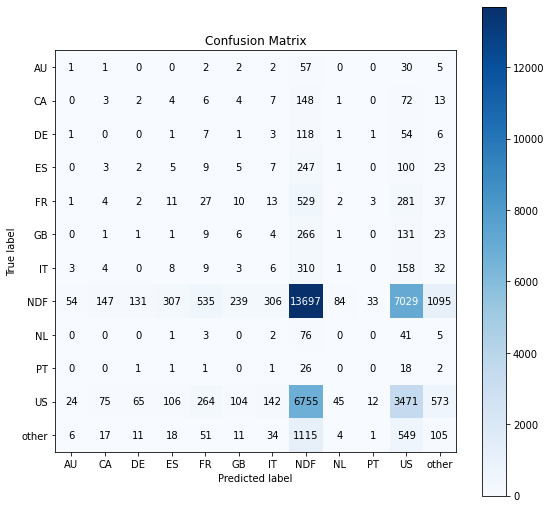

In [66]:
# random y_hat weighted
p = y_train.value_counts(normalize=True).sort_index().values
a = y_train.drop_duplicates().sort_index().sort_values()
y_hat = np.random.choice(a=a, size=len(y_test), p=p)

# formating target
y_hat = le_country_destination.inverse_transform(y_hat)
y_test_ = le_country_destination.inverse_transform(y_test)

# metrics
acc = m.accuracy_score(y_test_, y_hat)
balanced_acc = m.balanced_accuracy_score(y_test_, y_hat)
kappa = m.cohen_kappa_score(y_test_, y_hat)

print(f'Accuracy: {acc}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Kappa Score : {kappa}')
print('')
print(f'{m.classification_report(y_test_, y_hat)}')

mt.plot_confusion_matrix(y_test_, y_hat, normalize=False, figsize=(9, 9));

### 7.2.2 Neural Network MLP

#### 7.2.2.1 Neural Network Single Validation

In [67]:
# # encoding y for neural network
# ohe = pp.OneHotEncoder()
# ohe_y = ohe.fit(y.values.reshape(-1, 1))
# y_train_nn = ohe_y.transform(y_train.values.reshape(-1, 1)).toarray()

# # model definition
# nn_model = ml.Sequential()
# nn_model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
# nn_model.add(l.Dense(12, activation='softmax'))

# # model compile
# nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# # fiting model
# nn_model.fit(X_train, y_train_nn, epochs=30, verbose=0, batch_size=32)

# # predicting
# y_hat = nn_model.predict(X_test)

# # formating
# y_hat = ohe.inverse_transform(y_hat)
# y_hat = y_hat.reshape(1, -1)[0]
# y_test_nn = y_test.to_numpy()

# # metrics
# acc = m.accuracy_score(y_test_nn, y_hat)
# balanced_acc = m.balanced_accuracy_score(y_test_nn, y_hat)
# kappa = m.cohen_kappa_score(y_test_nn, y_hat)
    
# # prints
# print(f'Accuracy: {acc}')
# print(f'Balanced Accuracy: {balanced_acc}')
# print(f'Kappa Score : {kappa}')
# print('')
# print(f'{m.classification_report(y_test_nn, y_hat)}')
# mt.plot_confusion_matrix(y_test_nn, y_hat, normalize=False, figsize=(9, 9));

#### 7.2.2.2 Neural Network Crossvalidation

In [68]:
# acc_list, balanced_acc_list, kappa_list = [], [], []

# num_folds = 5
# i = 1
# skf = ms.StratifiedKFold(n_splits= num_folds, random_state=100, shuffle=True)

# for train_index, test_index in skf.split(X, y):
    
#     # get fold
#     X_train_fold = X.iloc[train_index]
#     y_train_fold = y.iloc[train_index]
    
#     X_test_fold = X.iloc[test_index]
#     y_test_fold = y.iloc[test_index]
  

#     # encoding y
#     y_train_fold = ohe_y.transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
#     # model definition
#     nn_model = ml.Sequential()
#     nn_model.add(l.Dense(128, input_dim=X_train_fold.shape[1], activation='relu'))
#     nn_model.add(l.Dense(12, activation='softmax'))

#     # model compile
#     nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

#     # fiting model
#     nn_model.fit(X_train_fold, y_train_fold, epochs=30, verbose=0, batch_size=32)

#     # predicting
#     y_hat = nn_model.predict(X_test_fold)

#     # formating
#     y_hat = ohe_y.inverse_transform(y_hat)
#     y_hat = y_hat.reshape(1, -1)[0]
#     y_test_fold = y_test_fold.to_numpy()
    
#     # metrics
#     acc = m.accuracy_score(y_test_fold, y_hat)
#     acc_list.append(acc)
#     balanced_acc = m.balanced_accuracy_score(y_test_fold, y_hat)
#     balanced_acc_list.append(balanced_acc)
#     kappa = m.cohen_kappa_score(y_test_fold, y_hat)
#     kappa_list.append(kappa)
    
#     # prints
#     print(f'Fold Number: {i}')
#     print(f'Balanced Accuracy: {balanced_acc}')
#     print(f'Kappa Score : {kappa}\n')
#     i += i

### 7.2.1 XGBoost Classifier

#### 7.2.3.1 XGBoost Classifier Sigle Validation

Accuracy: 0.8757361162877376
Balanced Accuracy: 0.16679353960664822
Kappa Score : 0.7678577014806134



D:\My Drive\Pessoal\environments\data_science\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\My Drive\Pessoal\environments\data_science\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\My Drive\Pessoal\environments\data_science\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       100
          CA       0.00      0.00      0.00       260
          DE       0.00      0.00      0.00       193
          ES       0.00      0.00      0.00       402
          FR       0.00      0.00      0.00       920
          GB       0.50      0.00      0.00       443
          IT       0.00      0.00      0.00       534
         NDF       1.00      1.00      1.00     23657
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        50
          US       0.70      1.00      0.82     11636
       other       0.29      0.00      0.01      1922

    accuracy                           0.88     40245
   macro avg       0.21      0.17      0.15     40245
weighted avg       0.81      0.88      0.83     40245



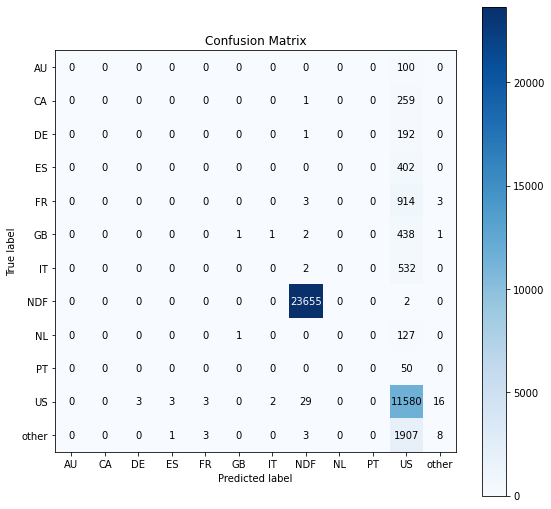

In [69]:
# model defition
xgb_model = XGBClassifier()

# fiting model
xgb_fit = xgb_model.fit(X_train.values, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# formating
y_hat = le_country_destination.inverse_transform(y_hat)
y_test = le_country_destination.inverse_transform(y_test)

# metrics
acc = m.accuracy_score(y_test, y_hat)
balanced_acc = m.balanced_accuracy_score(y_test, y_hat)
kappa = m.cohen_kappa_score(y_test, y_hat)
    
# prints
print(f'Accuracy: {acc}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Kappa Score : {kappa}')
print('')
print(f'{m.classification_report(y_test, y_hat)}');

mt.plot_confusion_matrix(y_test, y_hat, normalize=False, figsize=(9, 9));

#### 7.2.3.2 XGBoost Classifier Crossvalidation

In [70]:
# acc_list, balanced_acc_list, kappa_list = [], [], []

# num_folds = 5
# i = 1
# skf = ms.StratifiedKFold(n_splits= num_folds, random_state=100, shuffle=True)

# for train_index, test_index in skf.split(X, y):
    
#     # get fold
#     X_train_fold = X.iloc[train_index]
#     y_train_fold = y.iloc[train_index]
    
#     X_test_fold = X.iloc[test_index]
#     y_test_fold = y.iloc[test_index]
    
#     # encoding y
#     y_train_fold_le = le_country_destination.transform(y_train_fold)
    
#     # model defition
#     xgb_model = XGBClassifier()
    
#     # fiting model
#     xgb_fit = xgb_model.fit(X_train_fold, y_train_fold)

#     # predicting
#     y_hat = xgb_fit.predict(X_test_fold)
    
#     # formating
#     y_hat = le_y.inverse_transform(y_hat)
    
#     # metrics
#     acc = m.accuracy_score(y_test_fold, y_hat)
#     acc_list.append(acc)
#     balanced_acc = m.balanced_accuracy_score(y_test_fold, y_hat)
#     balanced_acc_list.append(balanced_acc)
#     kappa = m.cohen_kappa_score(y_test_fold, y_hat)
#     kappa_list.append(kappa)
    

#     # prints
#     print(f'Fold Number: {i}')
#     print(f'Balanced Accuracy: {balanced_acc}')
#     print(f'Kappa Score : {kappa}\n')
#     i += i

# 8.0 Model Performance

## 8.1 Machine Learning Performance

In [71]:
# # ENCODINGS
# le_country_destination

# # STANDARD SCALING
# ss_secs_elapsed
# cols_standard_scaler

# # RESCALING
# mm_age

# # MAPPINGS
# map_gender
# map_signup_method
# map_signup_flow
# map_language
# map_affiliate_channel
# map_affiliate_provider
# map_first_affiliate_tracked
# map_signup_app
# map_first_device_type
# map_first_browser
# map_signup_flow
# map_device_type
# map_year_first_active
# map_year_first_booking
# map_year_account_created

# month_fist_active_cicle
# day_first_active_cicle
# day_of_week_first_active_cicle
# week_of_year_first_active_cicle
# month_first_booking_cicle
# day_first_booking_cicle
# day_of_week_first_booking_cicle
# week_of_year_first_booking_cicle
# month_account_created_cicle
# day_account_created_cicle
# day_of_week_account_created_cicle
# week_of_year_account_created_cicle

# 9.0 Exportings

# ExecuteTime 

In [75]:
print(f'Tempo de total execução: {round((time.time() - time_init)/60, 2)} minutos')

Tempo de total execução: 6.3 minutos
